In [1]:
# 2️⃣ Kütüphaneler
import os
import pandas as pd
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
import matplotlib.pyplot as plt

In [2]:
# 3️⃣ OpenAI API Key
os.environ["OPENAI_API_KEY"] = ''

In [3]:
# 4️⃣ CSV dosyalarını oku ve birleştir
csv_folder = "dss_data"  # Örnek CSV klasörü
all_text = ""
df_all_sales = pd.DataFrame()
df_all_comp = pd.DataFrame()
df_all_market = pd.DataFrame()
df_all_prod = pd.DataFrame()

In [4]:
for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(csv_folder, file))
        if "company_sales" in file:
            df_all_sales = pd.concat([df_all_sales, df], ignore_index=True)
        elif "competitor_sales" in file:
            df_all_comp = pd.concat([df_all_comp, df], ignore_index=True)
        elif "market_trends" in file:
            df_all_market = pd.concat([df_all_market, df], ignore_index=True)
        elif "production_data" in file:
            df_all_prod = pd.concat([df_all_prod, df], ignore_index=True)
        # Metin formatına çevir (RAG için)
        csv_text = "\n".join([str(row.to_dict()) for idx, row in df.iterrows()])
        all_text += f"--- {file} ---\n{csv_text}\n\n"

print("✅ Tüm CSV verileri metin formatına dönüştürüldü.")

✅ Tüm CSV verileri metin formatına dönüştürüldü.


In [5]:
# 5️⃣ Vektör veritabanı oluştur
embeddings = OpenAIEmbeddings()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_text(all_text)
db = Chroma.from_texts(chunks, embeddings)
retriever = db.as_retriever()

# 6️⃣ LLM + RAG zinciri
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.2)
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
)


/tmp/ipython-input-3567824213.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


In [6]:
# 7️⃣ Otomatik Karar Destek Raporu ve Strateji Önerisi
report_prompt = (
    "Elimdeki kurumsal ve piyasa verilerini analiz et ve bir karar destek raporu hazırla:\n"
    "- Toplam satış ve gelir trendleri\n"
    "- En çok ve en az performans gösteren ürünler / alanlar\n"
    "- Rakip analizi ve fırsatlar\n"
    "- Risk analizi ve aksiyon önerileri\n"
    "- Strateji önerileri ve kısa özet"
)

report = qa_chain.run(report_prompt)


/tmp/ipython-input-3541097606.py:11: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  report = qa_chain.run(report_prompt)


In [7]:
# 8️⃣ Raporu dosyaya kaydet
output_file = "dss_full_report.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(report)

print(f"✅ Karar destek raporu '{output_file}' dosyasına kaydedildi.")
print("💡 Rapor önizlemesi (ilk 1000 karakter):\n")
print(report[:1000], "...")

✅ Karar destek raporu 'dss_full_report.txt' dosyasına kaydedildi.
💡 Rapor önizlemesi (ilk 1000 karakter):

Verileri analiz ettiğimizde:

1. **Toplam Satış ve Gelir Trendleri:**
   - 2025 yılında toplam gelirlerin en yüksek olduğu ay Şubat ayıdır.
   - 2025 yılında en düşük gelirler Ocak ayında elde edilmiştir.
   - Toplam gelirlerde artış eğilimi gözlemlenmektedir.

2. **En Çok ve En Az Performans Gösteren Ürünler/Alanlar:**
   - En çok satılan ürün Widget E'dir ve en çok gelir de bu üründen elde edilmiştir.
   - En az performans gösteren ürün Widget C'dir.

3. **Rakip Analizi ve Fırsatlar:**
   - CompX ve CompZ rakipler arasında en yüksek geliri elde eden firmalardır.
   - CompX, Widget E ürününde en iyi performansı göstermiştir.
   - CompZ'nin Widget B ürününde performansı zayıftır, bu alanda fırsatlar bulunmaktadır.

4. **Risk Analizi ve Aksiyon Önerileri:**
   - Rekabetin yoğun olduğu Widget E ürününde pazar payını artırmak için pazarlama stratejileri geliştirilmelidir.
   - En düş

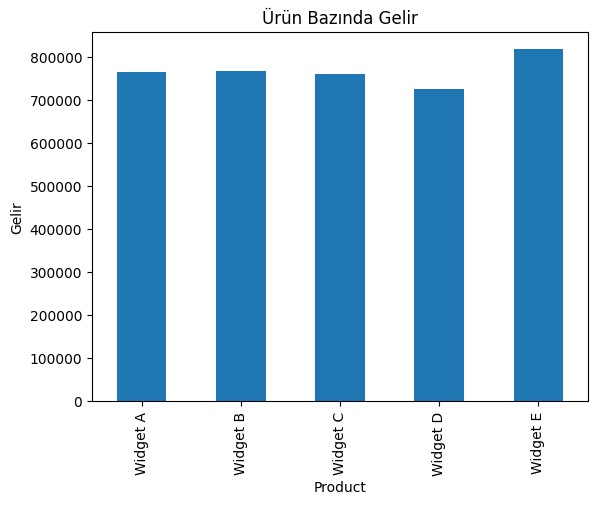

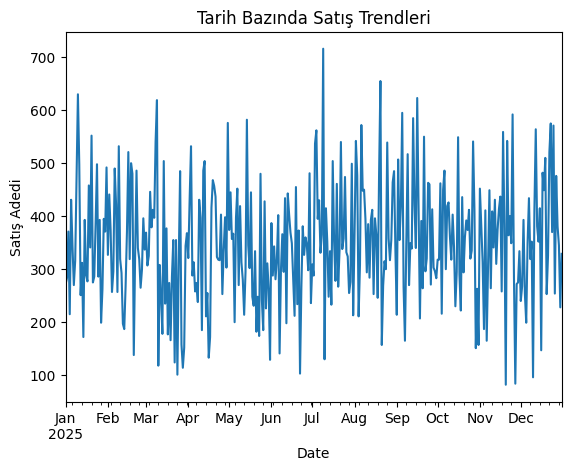

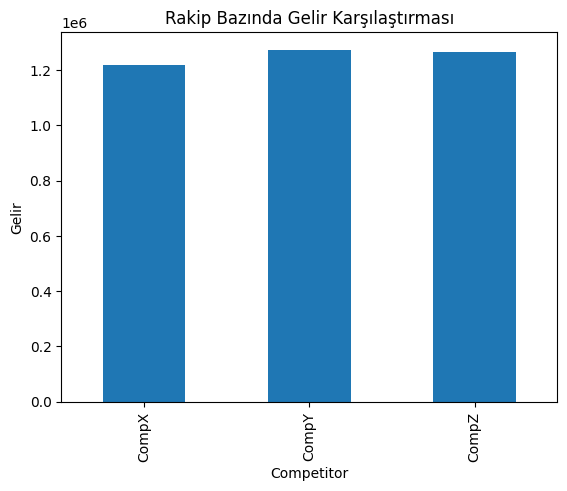

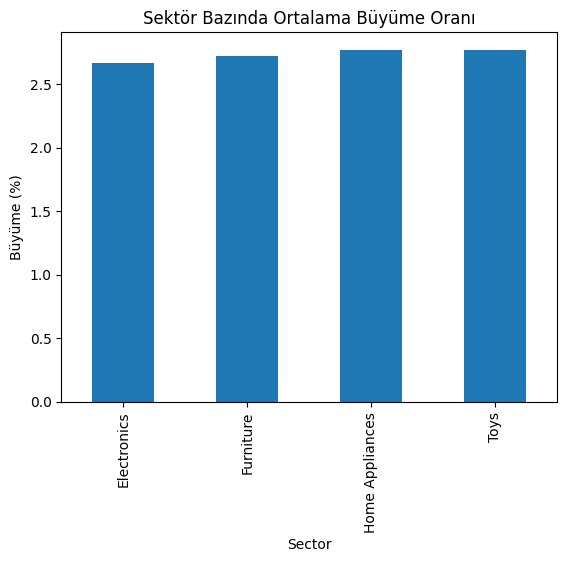

In [8]:
# 9️⃣ Grafikler

# Ürün bazında gelir
if not df_all_sales.empty:
    revenue_by_product = df_all_sales.groupby("Product")["Revenue"].sum()
    revenue_by_product.plot(kind="bar", title="Ürün Bazında Gelir")
    plt.ylabel("Gelir")
    plt.show()

# Tarih bazında satış trendi
if not df_all_sales.empty:
    df_all_sales['Date'] = pd.to_datetime(df_all_sales['Date'])
    sales_by_date = df_all_sales.groupby('Date')["Quantity"].sum()
    sales_by_date.plot(kind="line", title="Tarih Bazında Satış Trendleri")
    plt.ylabel("Satış Adedi")
    plt.show()

# Rakip ürün gelir karşılaştırması
if not df_all_comp.empty:
    competitor_revenue = df_all_comp.groupby("Competitor")["Revenue"].sum()
    competitor_revenue.plot(kind="bar", title="Rakip Bazında Gelir Karşılaştırması")
    plt.ylabel("Gelir")
    plt.show()

# Piyasa trendleri örneği
if not df_all_market.empty:
    sector_growth = df_all_market.groupby("Sector")["GrowthRate (%)"].mean()
    sector_growth.plot(kind="bar", title="Sektör Bazında Ortalama Büyüme Oranı")
    plt.ylabel("Büyüme (%)")
    plt.show()